In [13]:
%matplotlib inline

import pylab
import utils.pcraster_utils as pcru
import numpy as np
import pcraster as pcr
import rasterio as rio
import matplotlib.pyplot as plt
import glob
import subprocess
import os

pylab.rcParams['figure.figsize'] = (15.0, 15.0)

1. Clip soil parameters by catchment
2. Read pre-computed variables (HAND, DIST, FA, LDD)
3. Compute FFSI

In [14]:
id = '2050088390'

def get_path(path_format, id):
    files = glob.glob(path_format.format(id))
    assert(len(files) == 1)

    return files[0]

def convert2tif(input_path, output_path):
    cmd = 'rio convert {0} {1} --co COMPRESS=DEFLATE'.format(input_path, output_path)
    subprocess.check_call(cmd, shell=True)

def warp(input_path, output_path, template_path):
    cmd = 'rio warp {0} {1} --like {2} --resampling cubic'.format(input_path, output_path, template_path)
    subprocess.check_call(cmd, shell=True)
    
def read(path):
    img = rio.open(path)
    # print(path + ': ' + str(img.get_nodatavals()[0]))
    return img.read()[0]


In [15]:
# define paths
path_soil_depth_full = '../shared/soil/FirstZoneCapacity.tif'
path_soil_porosity_full = '../shared/soil/thetaS.tif'
path_soil_ksat_full = '../shared/soil/FirstZoneKsatVer.tif'

path_ldd = get_path('../output/continents/ldd/*{0}*.tif', id)
path_dem = get_path('../output/continents/dem/*{0}*.tif', id)
path_uparea = get_path('../output/continents/fa/*{0}*.tif', id)
path_hand = get_path('../output/continents/hand-1000/*{0}*.tif', id)
path_dist = get_path('../output/continents/dist-1000/*{0}*.tif', id)
path_soil_depth = '../temp/{0}_FirstZoneCapacity.tif'.format(id)
path_soil_porosity = '../temp/{0}_thetaS.tif'.format(id)
path_soil_ksat = '../temp/{0}_FirstZoneKsatVer.tif'.format(id)

In [17]:
# clip top soil layer properties to DEM
warp(path_soil_depth_full, path_soil_depth, path_dem)
warp(path_soil_porosity_full, path_soil_porosity, path_dem)
warp(path_soil_ksat_full, path_soil_ksat, path_dem)

In [18]:
# read top soil layer properties
soil_depth = read(path_soil_depth)
soil_porosity = read(path_soil_porosity)
soil_ksat = read(path_soil_ksat)

In [24]:
# read ldd, uparea, hand, dist
ldd = read(path_ldd)
dem = read(path_dem)
uparea = read(path_uparea)
hand = read(path_hand)
dist = read(path_dist)

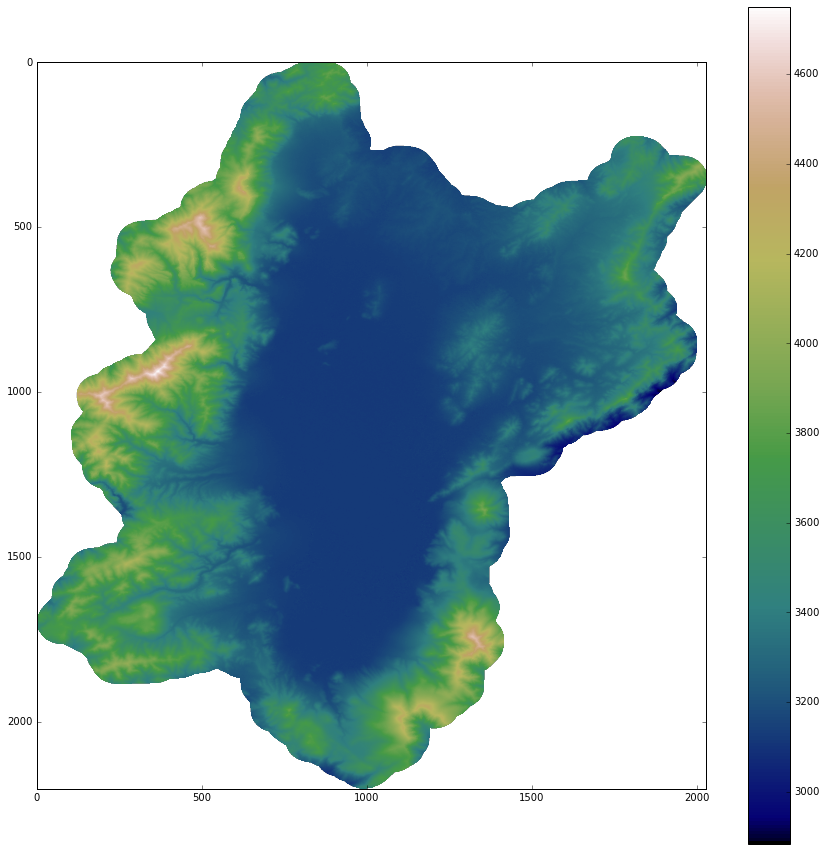

In [20]:
dem = np.ma.masked_equal(read(path_dem), -9999)
plt.imshow(dem, cmap=plt.cm.gist_earth)
plt.colorbar()

In [21]:
pcru.initialize(path_ldd)

In [22]:
ranges = {'HAND': [0,800], 'DIST':[0,3000], 'UP_AREA': [0, 12], 'UP_SLOPE': [0, 1], 'SOIL_DEPTH': [0, 1300], 'SOIL_INF': [0, 20]}

In [25]:
scale = 30. # scale in meters
scores = pcru.computeFFSI(dem, ldd, uparea, dist, hand, soil_depth, soil_ksat, soil_porosity, scale, ranges, False)

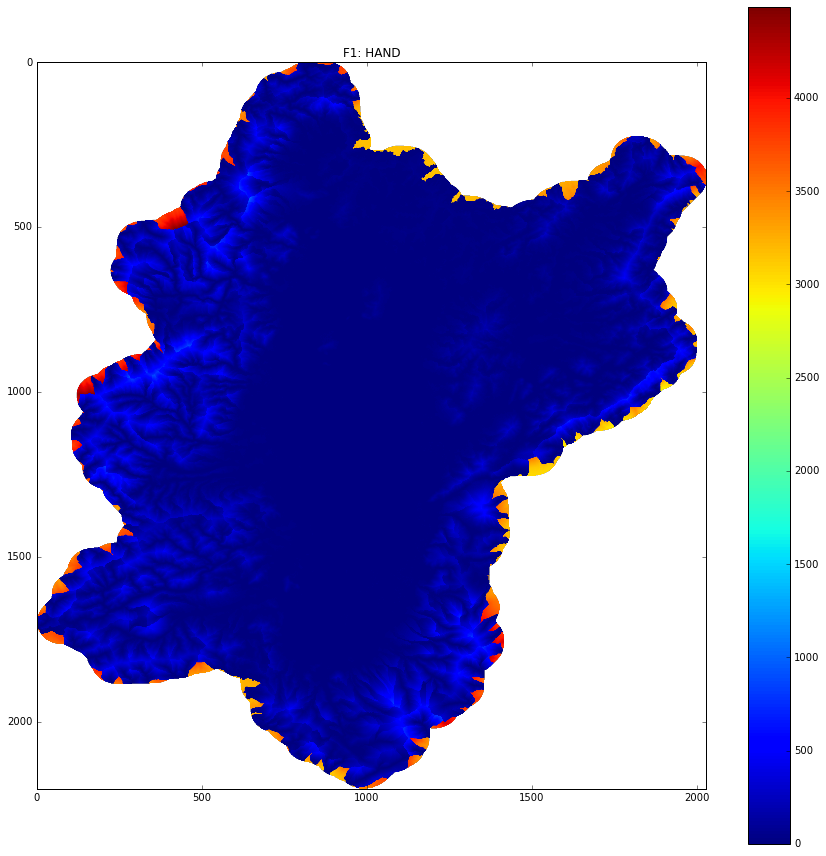

In [26]:
pcru.showmap(scores[0], 'F1: HAND')

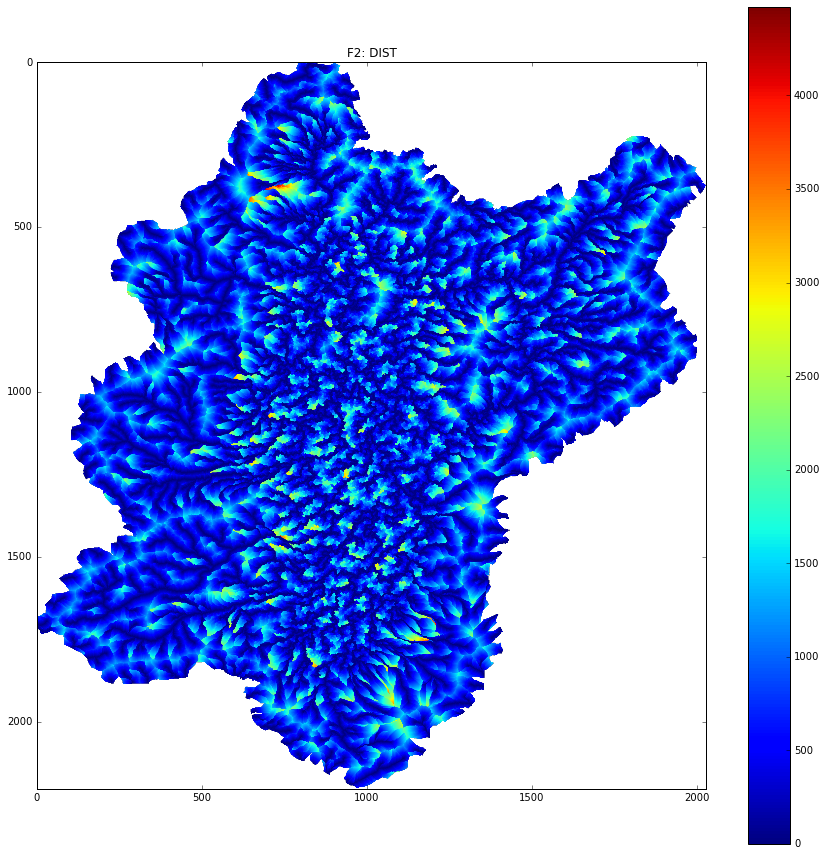

In [27]:
pcru.showmap(scores[1], 'F2: DIST')

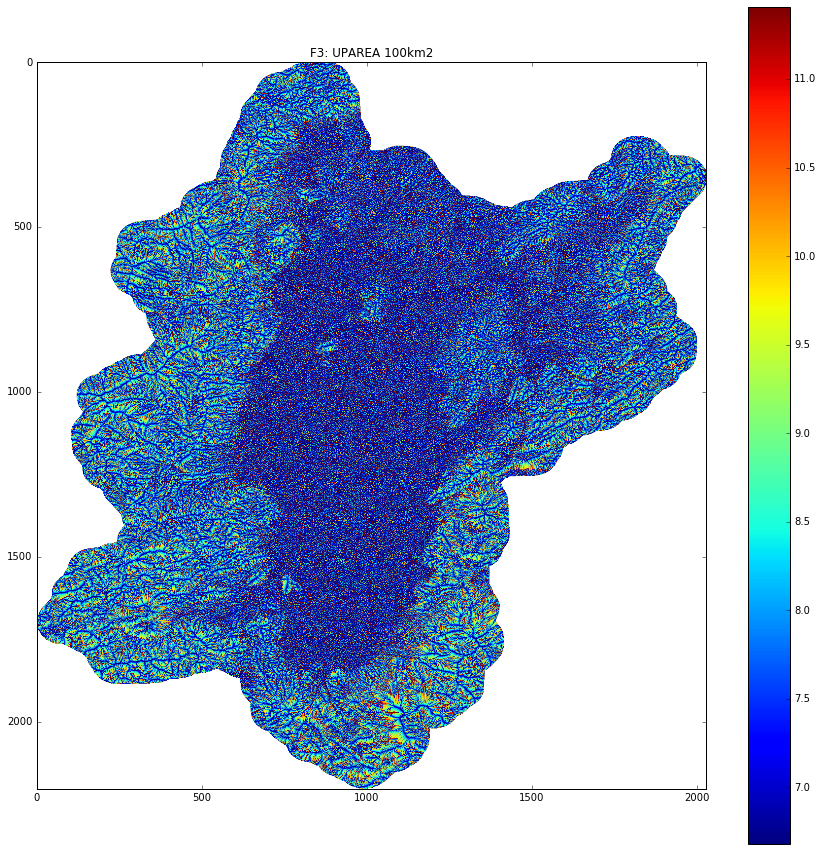

In [28]:
pcru.showmap(scores[2], 'F3: UPAREA 100km2')

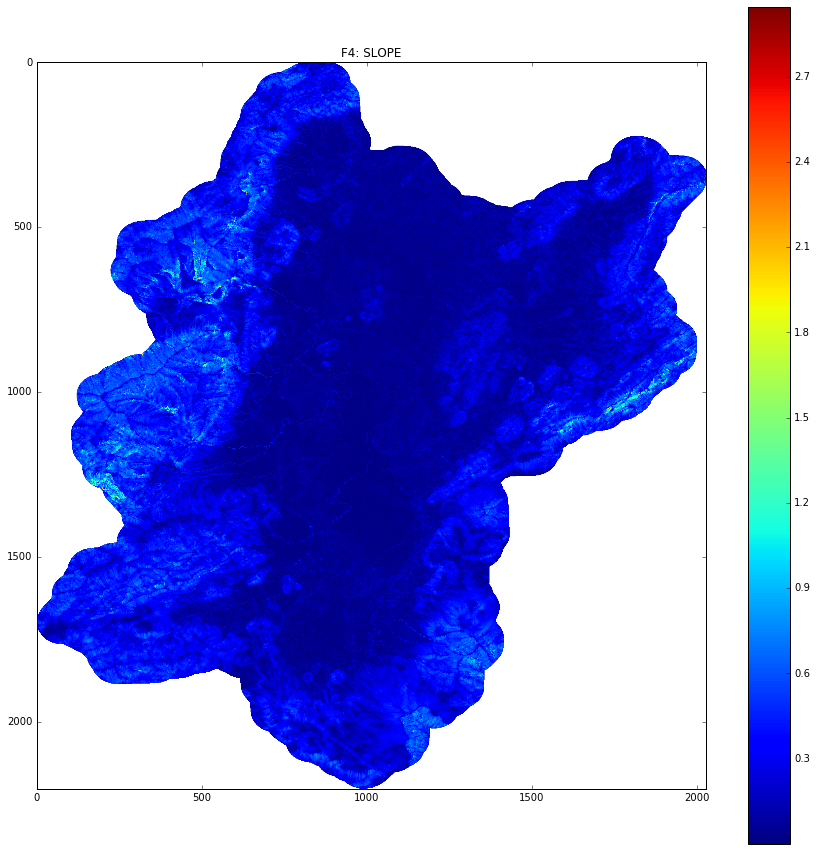

In [29]:
pcru.showmap(scores[3], 'F4: SLOPE')

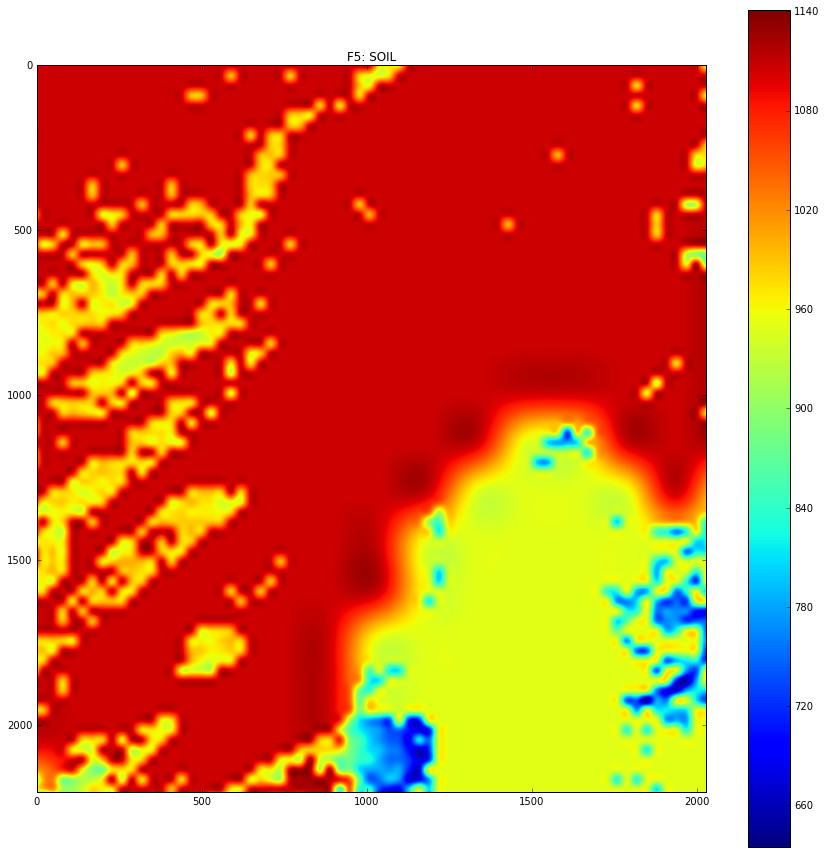

In [30]:
pcru.showmap(scores[4], 'F5: SOIL')

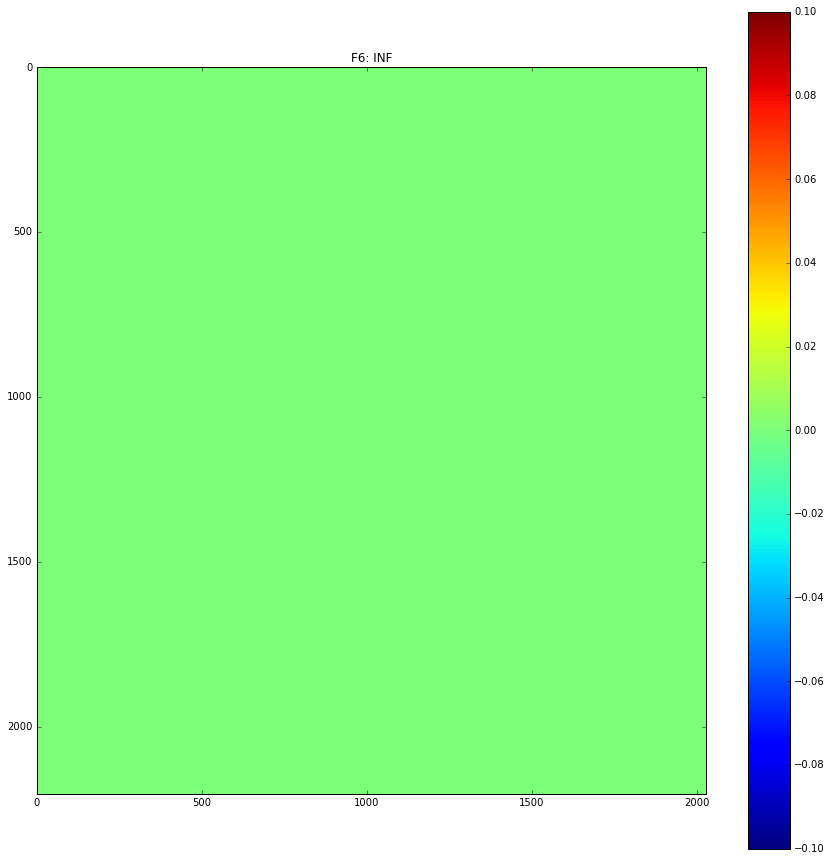

In [31]:
pcru.showmap(scores[5], 'F6: INF')

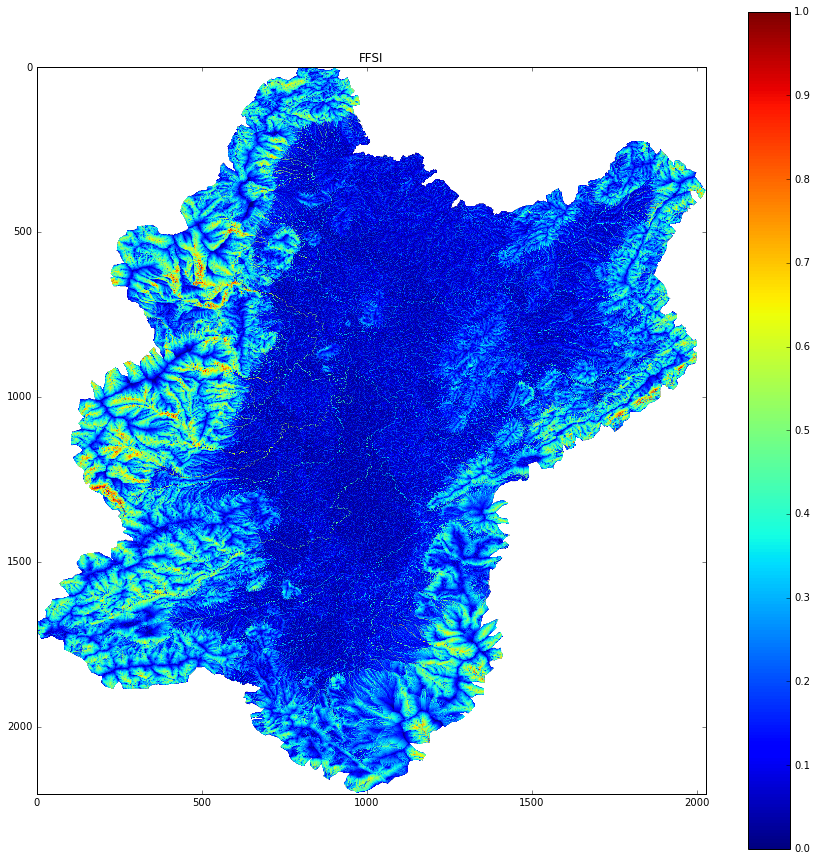

In [32]:
pcru.showmap(scores[6], 'FFSI')

In [ ]:
def get_hist(a):
    aa = pcr.pcr_as_numpy(a)
    h = np.histogram(aa[~np.isnan(aa)], bins=100)
    return {'frequency':h[0].tolist(), 'value':h[1].tolist()}

def compute_FFSI(id):
    global histograms
    
    print(id)
    
    path_ldd = get_path('../output/continents/ldd/*{0}*.tif', id)
    path_dem = get_path('../output/continents/dem/*{0}*.tif', id)
    path_uparea = get_path('../output/continents/fa/*{0}*.tif', id)
    path_hand = get_path('../output/continents/hand-1000/*{0}*.tif', id)
    path_dist = get_path('../output/continents/dist-1000/*{0}*.tif', id)
    path_soil_depth = '../temp/{0}_FirstZoneCapacity.tif'.format(id)
    path_soil_porosity = '../temp/{0}_thetaS.tif'.format(id)
    path_soil_ksat = '../temp/{0}_FirstZoneKsatVer.tif'.format(id)    
    
    # clip top soil layer properties to DEM
    path_soil_depth_full = '../shared/soil/FirstZoneCapacity.tif'
    path_soil_porosity_full = '../shared/soil/thetaS.tif'
    path_soil_ksat_full = '../shared/soil/FirstZoneKsatVer.tif'

    warp(path_soil_depth_full, path_soil_depth, path_dem)
    warp(path_soil_porosity_full, path_soil_porosity, path_dem)
    warp(path_soil_ksat_full, path_soil_ksat, path_dem)
    
    # read top soil layer properties
    soil_depth = read(path_soil_depth)
    soil_porosity = read(path_soil_porosity)
    soil_ksat = read(path_soil_ksat)

    # read ldd, uparea, hand, dist
    ldd = read(path_ldd)
    dem = read(path_dem)
    uparea = read(path_uparea)
    hand = read(path_hand)
    dist = read(path_dist)
    
    pcru.initialize(path_ldd)
    
    scale = 30. # scale in meters
    
    # ffsi = pcru.computeFFSI(dem, ldd, uparea, dist, hand, soil_depth, soil_ksat, soil_porosity, scale)[6]
    
    (s_hnd, s_dst, s_upstr, s_ustrslope, s_soildhaz, s_soilinfhaz, s_ffsi) \
       = pcru.computeFFSI(dem, ldd, uparea, dist, hand, soil_depth, soil_ksat, soil_porosity, scale)
    
    hist = { \
                'HAND': get_hist(s_hnd), \
                'DIST': get_hist(s_dst), \
                'UP_AREA': get_hist(s_upstr), \
                'UP_SLOPE': get_hist(s_ustrslope), \
                'SOIL_DEPTH': get_hist(s_soildhaz), \
                'SOIL_INF': get_hist(s_soilinfhaz), \
                'FFSI': get_hist(s_ffsi), \
              }

    with open('../examples/FFSI/Afganistan/output/histograms/' + id + '_hist.json', 'w') as outfile:
        json.dump(hist, outfile)
    
    # map_path = '../examples/FFSI/Afganistan/output/catchments/FFSI_{0}.map'.format(id)
    # pcr.report(ffsi, map_path)
    
    # tif_path = '../examples/FFSI/Afganistan/output/catchments/FFSI_{0}.tif'.format(id)
    # convert2tif(map_path, tif_path)
    
    # os.remove(map_path)
    
    os.remove(path_soil_depth)
    os.remove(path_soil_porosity)
    os.remove(path_soil_ksat)


In [ ]:
# generate for all catchments of Afganistan

ids = file('../examples/FFSI/Afganistan/ids.txt', 'r').read().splitlines()
print(len(ids))


In [ ]:
compute_FFSI(ids[0])

In [10]:
# computing locally crashes so we run the above function (compute_FFSI) as a separate process

import utils.compute_ffsi as ffsi_cmd

ffsi_cmd.compute_all()

TypeError: compute_all() takes exactly 1 argument (0 given)

In [ ]:
def plot(hist, var):
    h = hist[var]

    x = h['value']
    y = h['frequency']
    # plt.plot(x[1:], y, 'b-', alpha=0.5)
    plt.plot(x[1:], y, 'b-')
    plt.title(var)
    
def plot_histograms(hist):
    plt.subplot(4, 2, 1)
    plot(hist, 'HAND')
    plt.xlim(0, 1000)

    plt.subplot(4, 2, 2)
    plot(hist, 'DIST')
    plt.xlim(0, 5000)

    plt.subplot(4, 2, 3)
    plot(hist, 'UP_AREA')

    plt.subplot(4, 2, 4)
    plot(hist, 'UP_SLOPE')

    plt.subplot(4, 2, 5)
    plot(hist, 'SOIL_DEPTH')

    plt.subplot(4, 2, 6)
    plot(hist, 'SOIL_INF')

    #plt.subplot(4, 2, 7)
    #plot(hist, 'FFSI')


In [ ]:
hist_files = glob.glob('../examples/FFSI/Afganistan/output/histograms/*.json')

print(len(hist_files))

print(hist_files[0])
print(hist_files[0][-20:-10])

In [ ]:
h = {'HAND':None}
print(h['HAND'])

In [ ]:
hist_all = {'HAND': None, 'DIST': None, 'UP_AREA': None, 'UP_SLOPE': None, 'SOIL_DEPTH': None, 'SOIL_INF': None}
            
# merge histograms, assuming the same bin ranges
def merge_hist(hist, v):
    hist_existing = hist_all[v]
    if not hist_existing:
        hist_all[v] = {'frequency': hist['frequency'], 'value': hist['value']}
    else:
        hist_all[v]['frequency'] = np.add(hist_all[v]['frequency'], hist['frequency'])

for path in hist_files:
    id = int(path[-20:-10])

    with open(path, 'r') as f:
        hist = json.load(f)
        map(lambda v: merge_hist(hist[v], v), hist_all.keys())

plot_histograms(hist_all)
plt.show()

In [ ]:
# compute 95% percentiles 
for k in hist_all.keys():
    p = np.percentile(hist_all[k]., 50)

In [ ]:
for path in hist_files:
    id = int(path[-20:-10])

    with open(path, 'r') as f:
        hist = json.load(f)
        plot_histograms(hist)

plt.show()

In [ ]:
# convert FFSI computed by catchment to a single tile (clip by catchments and merge)
!../examples/FFSI/Afganistan/tile.sh